![logo](https://www.databolt.tech/images/logo.png)
Accelerate data science [www.databolt.tech](https://www.databolt.tech) | [github.com/d6t/d6t-python](https://github.com/d6t/d6t-python)

# Explaining "Blackbox" ML Models - Practical Application of SHAP

Train a "blackbox" GBM model on a real dataset and make it explainable with SHAP. 

## Motivation

GBM models have been battle-tested as powerful models but have been tainted by the lack explainability. Typically data scientists look at variable importance plots but they are not enough to explain how a model works. To maximize adoption by the model user, use SHAP values to answer common explainability questions and build trust in your models. 

In this post, we will train a GBM model on a simple dataset and you will learn how to explain how the model works. The goal here is not to explain how the math works, but to explain to a non-technical user how the input variables are related to the output variable and how predictions are made.

The dataset we are using is the advertising dataset provided by [ISLR](http://faculty.marshall.usc.edu/gareth-james/ISL/) and you can get the code used on [d6t github](http://tiny.cc/d6t-blog-20200426-shapley).

## First, build highly effective data science workflows

As explained in [Top 10 Coding Mistakes Made by Data Scientists](https://github.com/d6t/d6t-python/blob/master/blogs/top10-mistakes-coding.md), to make a highly effective data science workflow, we will be using file manager [d6tpipe](https://github.com/d6t/d6tpipe) and workflow manager [d6tflow](https://github.com/d6t/d6tflow).

In [ ]:
api = d6tpipe.APIClient()
pipe = d6tpipe.Pipe(api, 'intro-stat-learning')
pipe.pull()

In [9]:
# preprocessing workflow

class TaskProcessRawData(d6tflow.tasks.TaskPqPandas):

    def run(self):
        df = pd.read_csv(pipe.dirpath/'Advertising.csv', usecols=[1,2,3,4])
        self.save(df)

@d6tflow.requires(TaskProcessRawData)
class TaskFeatures(d6tflow.tasks.TaskPqPandas):
    
    def run(self):
        df = self.inputLoad()
        df['target']=df['sales']
        df['radio']=-df['radio'] # force negative relationship
        df['tv_radio']=df['TV']*df['radio'] # interaction effect
        self.save(df)
        
print('preprocessing workflow:')
d6tflow.preview([TaskFeatures()])

preprocessing workflow:

└─--[TaskFeatures-{} (COMPLETE)]
   └─--[TaskProcessRawData-{} (COMPLETE)]


## Second, don't build a model without having an intuition on what it should do

As explained in [Top 10 Statistics Mistakes Made by Data Scientists](https://github.com/d6t/d6t-python/blob/master/blogs/top10-mistakes-statistics.md), you want to form an economic intuition on how the model should work. 

The advertising dataset shows sales as a function of advertising spend in TV, radio and newspaper. By looking at the scatter plots, we can tell TV and radio are effective marketing channels because sales is strongly related to spend in those channels. But note that radio has a negative impact while TV has a positive impact (NB we forced a negative relationship with radio). Newspaper seems to only have a marginal impact. Finally, there seems to be an interaction effect between TV and radio.

In [11]:
df_train = TaskFeatures().outputLoad()
cfg_col_X = ['TV', 'radio', 'newspaper'] # base features
cfg_col_X_interact =  cfg_col_X+['tv_radio'] # includes interaction variable
cfg_col_Y = 'target'
df_trainX, df_trainY = df_train[cfg_col_X], df_train[cfg_col_Y]

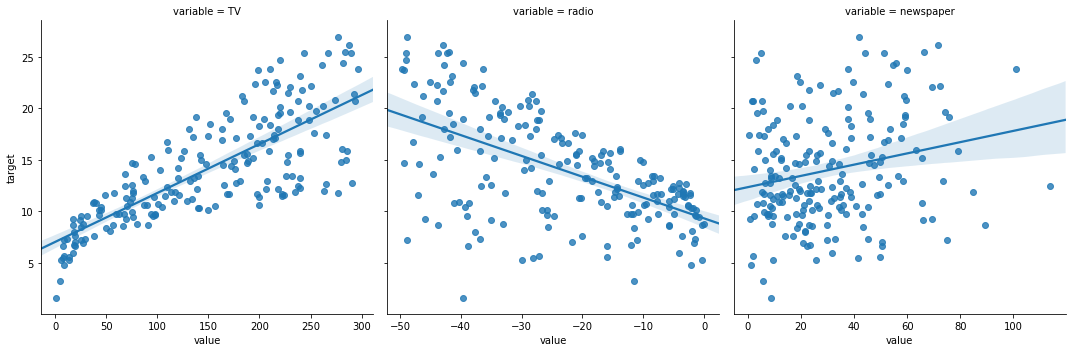

In [21]:
dfp = df_train.melt(id_vars=cfg_col_Y,value_vars=cfg_col_X)
sns.lmplot(x="value", y="target", col="variable", data=dfp, sharex=False);

## Now train a "black box" ML model

GBM models have been battle-tested as powerful models but have been tainted by the lack explainability. Lets train the model and see how we can explain it. We will be using [LightGBM](https://lightgbm.readthedocs.io/en/latest/).

In [ ]:
m_lgbm = lightgbm.LGBMRegressor()
m_lgbm.fit(df_trainX,df_trainY)

##  Why variable importance plots don't work

As the name suggests, variable importance plots tells you about the strength of relationship between an input and output variable. But to trust a model, users typically want to know more: is the impact positive/negative, linear/non-linear? Are there times when it works/does not work? They want to see if the model conforms with their economic intuition. 

In our example, the importance plot does not show newspaper spend with a negative relationship that we established to be there. This would confuse the model user and they would not trust the model based on this plot alone.

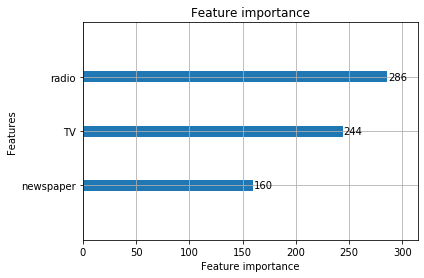

In [14]:
lightgbm.plot_importance(m_lgbm);

## Explain the model with SHAP

[SHAP](https://github.com/slundberg/shap) allows you to see the directional impact of each input on the output variable and this gives the model user the crucial intuition on how the model works. 

As you can see, the model indeed shows higher sales for higher TV spend and lower sales for higher radio spend. This is inline with our intuition and gives the model user confidence that your model does the right thing.

In [15]:
explainer = shap.TreeExplainer(m_lgbm, df_trainX)
shap_values = explainer.shap_values(df_trainX)

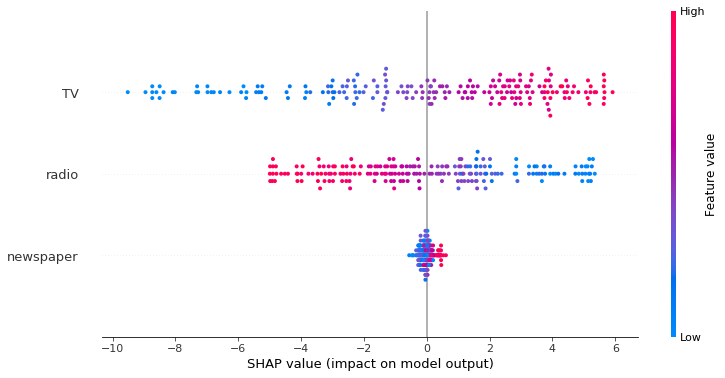

In [16]:
shap.summary_plot(shap_values, df_trainX, plot_size=(12,6))

You can also investigate the "fitted" values in a scatter plot to visualize the relationship between the input and output variable in more detail. This is useful for more complex relationships and understanding interaction effects. 

In this case, the relationship is linear and there is an interaction between TV and radio (you can confirm by running OLS and include the `tv_radio` variable).

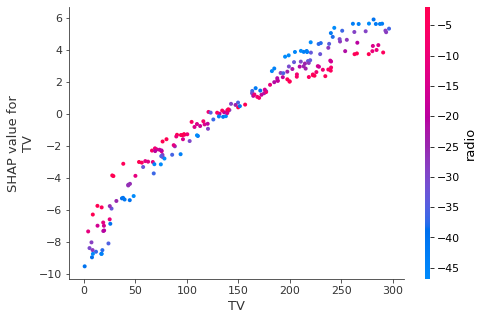

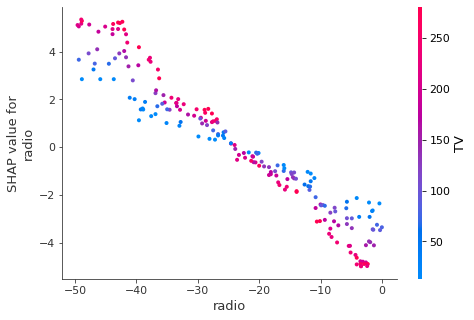

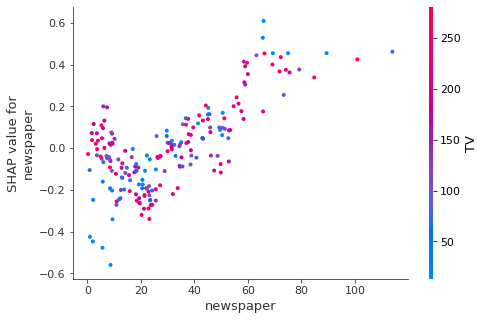

In [17]:
for col in cfg_col_X:
    shap.dependence_plot(col, shap_values, df_trainX)

## What about partial dependence plots?

Those work also. The advantage is that their output is in the same scale as the actual target variable. This is unlike Shapley values which show the marginal impact relative to the average forecast. 

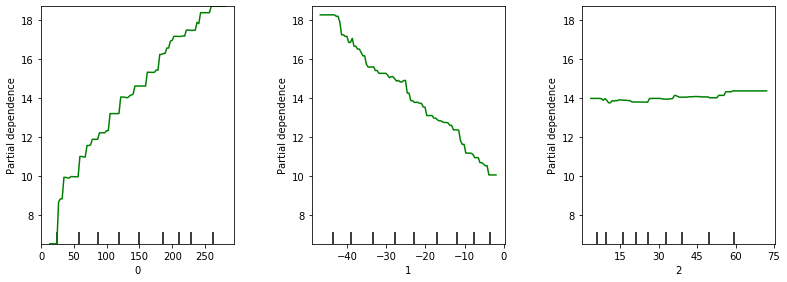

In [18]:
matplotlib.rcParams['figure.figsize'] = (12,6)
plot_partial_dependence(m_lgbm, df_trainX, range(df_trainX.shape[1])) 

## Explain the latest forecasts

This is another question commonly encountered in practice: you have trained the model and make a prediction using the latest data. The model user wants to know not just the predicted value but also why your model makes that prediction. SHAP can explain individual predictions and can explain how each input variable contributes to the overall prediction.

Here we can see the latest predicted value is [13.18]. TV pushed the prediction up while radio pushed it down. Newspaper barely had an impact. This is inline with what we expected.

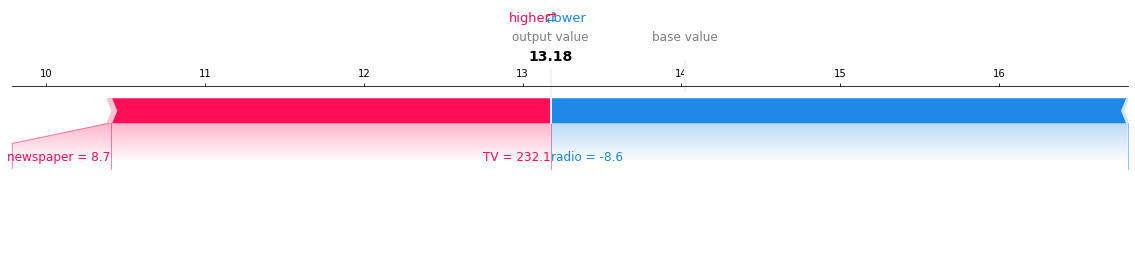

In [19]:
shap.force_plot(explainer.expected_value, shap_values[-1,:], df_trainX.iloc[-1,:],matplotlib=True)

## Where to learn more?

Understand SHAP  
* https://github.com/slundberg/shap 
* https://christophm.github.io/interpretable-ml-book/shap.html

Build highly effective data science workflows
* https://github.com/d6t/d6t-python/blob/master/blogs/effective-datasci-workflows.rst
* https://github.com/d6t/d6tflow-template

Accelerate data science with Databolt
* https://github.com/d6t/d6t-python
* https://www.databolt.tech/